# Figure 5 - Precipitation (Summer)

# 1 - Import Necessary Modules

In [2]:
import cartopy 
import cartopy.io.shapereader as shpreader 
import cartopy.io.shapereader as Reader 
import geopandas as gpd
import matplotlib.pyplot as plt 
import numpy as np 
import proplot as plot
import proplot
import salem
import xarray as xr 

from cartopy.feature import ShapelyFeature 
from glob import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from netCDF4 import Dataset 
from shapely.geometry import mapping
from visjobs.visualize import easy_plot
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy 

# warnings
import warnings
warnings.filterwarnings('ignore')

# 1. IMERG
## 1.1 Open Dataset

In [2]:
#imerg verisi yaz için indirilmedi İNDİR!
def read_netcdfs(files, dim):
    # glob expands paths with * to a list of files, like the unix shell
    paths = sorted(glob(files))
    datasets = []
    for p in paths:
        nd = xr.open_dataset(p)
        datasets.append(nd)
    combined = xr.concat(datasets, dim)
    return combined

combined_30min = read_netcdfs(r'\datasets\summer_dataset\*20160828*', dim='time')
ir_pr = combined_30min['IRprecipitation']

## 1.2 Resample dataset as hourly

In [3]:
"""
Verileri 30 dk aralıklı ama mm/hour birimi. Bu nedenle biz yarım saatlik olan her değeri 2'ye böleceğiz, ve günlük toplamı bulurken 
00 UTC'den 23 UTC'ye kadar olan tüm değerlerin toplamını alacağız.
"""

IMERG_mm_30min = ir_pr/2 
IMERG_mm_hr    = IMERG_mm_30min.resample(time = '1H').sum()
IMERG_mm_day   = IMERG_mm_hr.sum(dim='time')

# 2. MGM Station
## 2.1 Open data

In [4]:
# istasyon verisi
dt_mgm = pd.read_excel(r'\datasets\ankara_P_tümveri_0918.xlsx', sheet_name='ankara_1318_p')

In [5]:
def prepare_obs_event_dataset(data, start, end):
    """
    data: Pandas Data
    start: desired start date (e.g., '2009-01-01 00')
    end: desired end date
    """
    data_copy = data.copy(deep=True)
    data_start = str(data['year'].iloc[0]) + str(data['month'].iloc[0]) + str(data['day'].iloc[0]) + str(data['hour'].iloc[0])
    data_end = str(data['year'].iloc[-1]) + str(data['month'].iloc[-1]) + str(data['day'].iloc[-1]) + str(data['hour'].iloc[-1])
    data_start = pd.to_datetime(int(data_start), format='%Y%m%d%H')
    data_end = pd.to_datetime(int(data_end), format='%Y%m%d%H')

    data_copy.index = pd.date_range(data_start, data_end, freq='1H') #set datetime index
    del data_copy['year'], data_copy['month'], data_copy['day'], data_copy['hour']    
    data_copy = data_copy.loc[start : end]
    return data_copy

In [6]:
MGM_mm_hr = prepare_obs_event_dataset(dt_mgm, '2016-08-28 00', '2016-08-28 23')
del MGM_mm_hr[17725] #Has NaN values ; useless

In [7]:
MGM_mm_day = MGM_mm_hr.sum(axis = 0)

In [8]:
"""
 ----- İstasyon Bilgileri ---------
"""

stations = list(MGM_mm_hr.columns.values)
lat_lon = [[39.9727, 32.8637],#17047
           [39.8032, 32.8434],#17059
           [39.7985, 32.9716],#17061
           [39.1525, 32.1283],#17062
           [40.4729, 32.6441],#17064
           [40.1733, 31.332],#17065
           [40.1608, 31.9172], #17388
           [39.92, 33.2125], #17389
           [39.5834, 32.1624],#17437
           [39.5546, 33.1089],#17438
           [38.9539, 33.4218],#17448
           [39.613, 32.672],#17454
           [39.7414, 32.38], #17455
           [40.0386, 33.2908],#17604
           [40.03, 32.2345],#17610
           [39.9075, 32.8494],#17636,
           [40.0878, 32.8111],#17813
           [40.2725, 32.6897],#17814
           [39.9194, 32.9944],#18099
           [40.4839, 32.4608],#18100
           [40.0947, 33.4133],#18101
           [40.2111, 32.2472],#18396
           [39.5578, 31.9019],#18397
           [40.1408, 33.1081],#18399
           [40.5983, 32.5033],#18400
           [40.2867, 33.0108],#18401
           [40.0317, 32.8933],#18402
           [39.9986, 32.5814],#18403
           [39.9725, 32.8639],#18404
           [39.8572, 32.8219],#18421
           [39.4356, 32.5153],#18734
           [40.0761, 32.6075],#18735
           ]
        
lat_lon = np.array(lat_lon)

# 3. WRF RUNS
Burada her bir run için ayrı bir ens veri oluşturuyoruz
## 3.1 Create ensemble data

In [10]:
#ensemble_members = ['LIN', 'LIN_PBL2', 'THOMPSON', 'THOMPSON_PBL2', 'WSM6', 'WSM6_PBL2']

# geçici olarak alttaki listeyi kullanıyorum (henüz verilerin tamamı indirilmedi!)
ensemble_members = ['lin', 'thompson', 'wsm6']
runs = []
for ens in ensemble_members:
    # veriyi aç
    ALL = salem.open_wrf_dataset(r'\summer_datasets\ankara_{}_urban\wrfout_d03_2016-08-26_00_00_00'.format(ens))
    # yağış değişkenini ata
    tempor = ALL['PRCP']
    # olay günü toplamı al
    EVENTSUM = tempor.isel(time = slice(48, 70)).sum(dim='time', keep_attrs=True).copy(deep=True)
    #veriyi kapa
    ALL.close()   
    # veriyi listeye kaydet
    runs.append(EVENTSUM)

# tüm verileri concat et
ensemble_runs = xr.concat(runs, dim='ens')
ensemble_runs['ens'] = ensemble_members

In [11]:
d_locs = Dataset(r'\summer_datasets\ankara_thompson_urban\wrfout_d03_2016-08-26_00_00_00')

## 3.2 Corner coordinates

In [12]:
d_sol_alt3 = xy_to_ll(d_locs, 0, 0).values
d_sol_ust3 = xy_to_ll(d_locs, 0, 200).values
d_sag_alt3 = xy_to_ll(d_locs, 200, 0).values
d_sag_ust3 = xy_to_ll(d_locs, 200, 200).values

# 4. CMAP
 Cmap'imizi ayarlayalım günlük toplam için

In [13]:
# cmap for total urban and nourban daily precipitation
nws_precip_colors_total = [
    "#c2c4c4"
    "#04e9e7",  # 0.01 - 0.10 inches
    "#019ff4",  # 0.10 - 0.25 inches
    "#0300f4",  # 0.25 - 0.50 inches
    "#02fd02",  # 0.50 - 0.75 inches
    "#01c501",  # 0.75 - 1.00 inches
    "#008e00",  # 1.00 - 1.50 inches
    "#fdf802",  # 1.50 - 2.00 inches
    "#e5bc00",  # 2.00 - 2.50 inches
    "#fd9500",  # 2.50 - 3.00 inches
    "#fd0000",  # 3.00 - 4.00 inches
    "#d40000",  # 4.00 - 5.00 inches
    "#bc0000",  # 5.00 - 6.00 inches
    "#f800fd",  # 6.00 - 8.00 inches
    "#9854c6",  # 8.00 - 10.00 inches
    "#fdfdfd",
    "#8a5b06",
    "#ac86c2",
    "#bcc2c0",
    "#000000"]

clevs_total = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30,
         35, 40, 45, 50, 55, 60, 65, 75, 85]

obj_total = Gradient([[nws_precip_colors_total[0],clevs_total[0]],[nws_precip_colors_total[1],clevs_total[1]]],
               [[nws_precip_colors_total[1],clevs_total[1]],[nws_precip_colors_total[2],clevs_total[2]]],
               [[nws_precip_colors_total[2],clevs_total[2]],[nws_precip_colors_total[3],clevs_total[3]]],
               [[nws_precip_colors_total[3],clevs_total[3]],[nws_precip_colors_total[4],clevs_total[4]]],
               [[nws_precip_colors_total[4],clevs_total[4]],[nws_precip_colors_total[5],clevs_total[5]]],
               [[nws_precip_colors_total[5],clevs_total[5]],[nws_precip_colors_total[6],clevs_total[6]]],
               [[nws_precip_colors_total[6],clevs_total[6]],[nws_precip_colors_total[7],clevs_total[7]]],
               [[nws_precip_colors_total[7],clevs_total[7]],[nws_precip_colors_total[8],clevs_total[8]]],
               [[nws_precip_colors_total[8],clevs_total[8]],[nws_precip_colors_total[9],clevs_total[9]]],
               [[nws_precip_colors_total[9],clevs_total[9]],[nws_precip_colors_total[10],clevs_total[10]]],
               [[nws_precip_colors_total[10],clevs_total[10]],[nws_precip_colors_total[11],clevs_total[11]]],
               [[nws_precip_colors_total[11],clevs_total[11]],[nws_precip_colors_total[12],clevs_total[12]]],
               [[nws_precip_colors_total[12],clevs_total[12]],[nws_precip_colors_total[13],clevs_total[13]]],
               [[nws_precip_colors_total[13],clevs_total[13]],[nws_precip_colors_total[14],clevs_total[14]]],
               [[nws_precip_colors_total[14],clevs_total[14]],[nws_precip_colors_total[15],clevs_total[15]]],
               [[nws_precip_colors_total[15],clevs_total[15]],[nws_precip_colors_total[16],clevs_total[16]]],
               [[nws_precip_colors_total[16],clevs_total[16]],[nws_precip_colors_total[17],clevs_total[17]]],
               [[nws_precip_colors_total[17],clevs_total[17]],[nws_precip_colors_total[18],clevs_total[18]]],)
int_pr_total = np.arange(1, 86.0, 1)
cmap_total = obj_total.get_cmap(int_pr_total) #Retrieve colormap
colors_total = obj_total.colors #Retrieve list of hex color values

# 5. Create Plot

In [14]:
#lon_imerg = IMERG_mm_day['lon']
#lat_imerg = IMERG_mm_day['lat']

lon_wrf = ensemble_runs['lon']
lat_wrf = ensemble_runs['lat']

In [15]:
#Define urban and rural box coordinates - 
urban_sol_alt_coordinates = [32.63, 39.85]
urban_sol_ust_coordinates = [32.63, 40.01]
urban_sag_alt_coordinates = [32.89, 39.85]
urban_sag_ust_coordinates = [32.89, 40.01]

### 5.2 Six-Facet plot

 Makale için görsel

In [16]:
# cmap for total urban and nourban daily precipitation
nws_precip_colors_total = [
    "#3f6394",
    "#4575b5",
    "#91bfdb",  # 0.01 - 0.10 inches
    "#dff2f7",  # 0.10 - 0.25 inches
    "#ffffbf",  # 0.25 - 0.50 inches
    "#ffe291",  # 0.50 - 0.75 inches
    "#fc8c58",  # 0.75 - 1.00 inches
    "#d62f27"]

clevs_total = [0, 5, 10, 15, 17, 20, 22, 24]

obj_total = Gradient([[nws_precip_colors_total[0],clevs_total[0]],[nws_precip_colors_total[1],clevs_total[1]]],
               [[nws_precip_colors_total[1],clevs_total[1]],[nws_precip_colors_total[2],clevs_total[2]]],
               [[nws_precip_colors_total[2],clevs_total[2]],[nws_precip_colors_total[3],clevs_total[3]]],
               [[nws_precip_colors_total[3],clevs_total[3]],[nws_precip_colors_total[4],clevs_total[4]]],
               [[nws_precip_colors_total[4],clevs_total[4]],[nws_precip_colors_total[5],clevs_total[5]]],
               [[nws_precip_colors_total[5],clevs_total[5]],[nws_precip_colors_total[6],clevs_total[6]]],
               [[nws_precip_colors_total[6],clevs_total[6]],[nws_precip_colors_total[7],clevs_total[7]]])
int_pr_total = np.arange(0, 31.0, 5)
cmap_total = obj_total.get_cmap(int_pr_total) #Retrieve colormap
colors_total = obj_total.colors #Retrieve list of hex color values

Discard IMERG

C:\Users\User\anaconda3\envs\berkay\lib\site-packages\proplot\figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)
C:\Users\User\anaconda3\envs\berkay\lib\site-packages\proplot\figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
C:\Users\User\anaconda3\envs\berkay\lib\site-packages\proplot\figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any

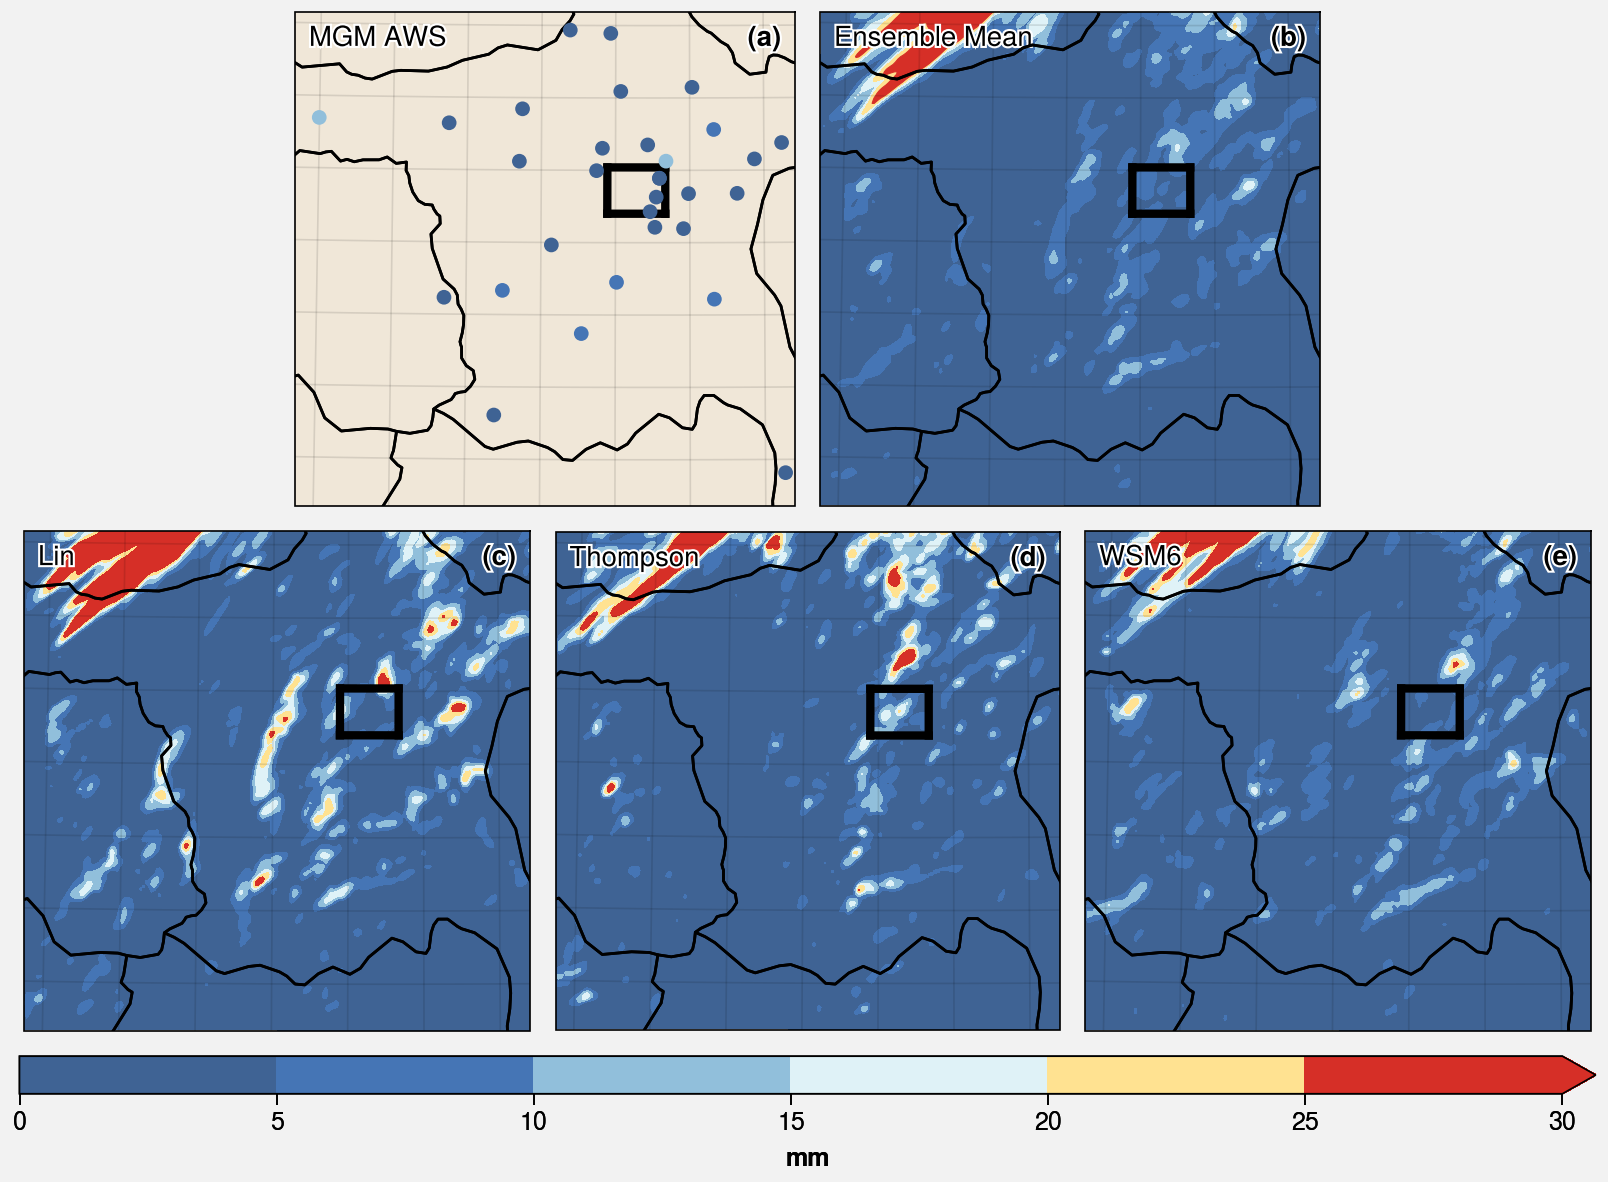

In [32]:
#Starting the plotting
cart_proj = cartopy.crs.LambertConformal( 32.834, 39.873 )
fig_array = [[0,1,1,2,2,0],
             [3,3,4,4,5,5]]
fig, axs = plot.subplots(fig_array, proj=cart_proj, span=False,  hratios=(1,1))

#format the plot
axs.format(
    lonlim=(d_sol_alt3[1], d_sag_alt3[1]-0.10), latlim=(d_sol_alt3[0], d_sol_ust3[0]-0.10), coast = True,
    labels=False, innerborders=True, reso = 'xx-hi', coastlinewidth = 2, innerborderslinewidth = 1,
    land = True, landcolor = '#f0e7d8', landzorder = 0.005, borderszorder = 3, innerborderszorder = 3, 
    abc=True, abcstyle='(a)', abcloc='ur')

axs.plot([urban_sol_alt_coordinates[0], urban_sol_ust_coordinates[0]], 
                [urban_sol_alt_coordinates[1], urban_sol_ust_coordinates[1]], 
                transform=cartopy.crs.PlateCarree(), color='black', linewidth=3.0)
axs.plot([urban_sol_ust_coordinates[0], urban_sag_ust_coordinates[0]], 
                [urban_sol_ust_coordinates[1], urban_sag_ust_coordinates[1]], 
                transform=cartopy.crs.PlateCarree(), color='black', linewidth=3.0)
axs.plot([urban_sag_ust_coordinates[0], urban_sag_alt_coordinates[0]], 
                [urban_sag_ust_coordinates[1], urban_sag_alt_coordinates[1]], 
                transform=cartopy.crs.PlateCarree(), color='black', linewidth=3.0)
axs.plot([urban_sol_alt_coordinates[0], urban_sag_alt_coordinates[0]], 
                [urban_sol_alt_coordinates[1], urban_sag_alt_coordinates[1]], 
                transform=cartopy.crs.PlateCarree(), color='black', linewidth=3.0)

# Imerg için plot
#IMERG_plot = axs[0].contourf(lon_imerg, lat_imerg, IMERG_mm_day.transpose(), levels = int_pr_total,
 #                            cmap=cmap_total, extend='max', 
  #                           transform=cartopy.crs.PlateCarree(), zorder = 0.01)
#axs[0].format(ultitle="IMERG", fontsize=10)


# MGM için plot
MGM_plot = axs[0].scatter(lat_lon[:,1], lat_lon[:,0], c = MGM_mm_day.values, marker = "o",
                          markersize = 22,
                          levels = int_pr_total,
                         cmap=cmap_total,
                        transform=cartopy.crs.PlateCarree(), zorder = 4)
axs[0].format(ultitle="MGM AWS", fontsize=10)

# ensemble mean için plot
run_plot = axs[1].contourf(lon_wrf, lat_wrf, ensemble_runs.mean(dim='ens'), levels = int_pr_total,
                           cmap=cmap_total, extend='max', 
                           transform=cartopy.crs.PlateCarree(), zorder = 0.01)
axs[1].format(ultitle="Ensemble Mean", fontsize=10)

ens_names = ['Lin', 'Thompson', 'WSM6']
# her bir ensemble elemanı için plot
for i in range(len(ensemble_runs['ens'])):
    run_plot = axs[i+2].contourf(lon_wrf, lat_wrf, ensemble_runs[i], levels = int_pr_total,
                           cmap=cmap_total, extend='max', 
                           transform=cartopy.crs.PlateCarree(), zorder = 0.01)
    axs[i+2].format(ultitle="{}".format(ens_names[i], fontsize=10))



fig.colorbar(run_plot, label='mm', labelweight='bold',
             ticks = np.concatenate([np.arange(0, 31, 5)]),
             loc = 'b')#Adding colorbar with label

plt.savefig(r'pictures/Summer28_Spatial_Dataset_Comparison_v3.jpeg',
            bbox_inches='tight', optimize=True, progressive=True, dpi=500)